In [ ]:
# Start writing code here...from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
spotify_songs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')


Q1 = np.percentile(spotify_songs.duration_ms, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(spotify_songs.duration_ms, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

"""
mask = (spotify_songs.duration_ms < (Q3+1.5*IQR))
mask2 = spotify_songs.duration_ms > (Q1-1.5*IQR)
spotify_data_cleaned = spotify_songs.loc[mask]
spotify_data_cleaned = spotify_data_cleaned.loc[mask2]
"""
spotify_data_cleaned = spotify_songs
spotify_data_cleaned.track_album_release_date.str[:4]
spotify_data_cleaned.track_album_release_date.str[5:7]
spotify_data_cleaned = spotify_data_cleaned.assign(
    track_album_release_month = spotify_data_cleaned.track_album_release_date.str[5:7],
    track_album_release_year = spotify_data_cleaned.track_album_release_date.str[:4],
)
spotify_data_cleaned.drop(columns="track_album_release_date",inplace=True)
spotify_data_cleaned.track_album_release_year = spotify_data_cleaned.track_album_release_year.astype("int64")
"""
mask = (spotify_data_cleaned.track_popularity > 0)
spotify_data_cleaned = spotify_data_cleaned.loc[mask]
"""


'\nmask = (spotify_data_cleaned.track_popularity > 0)\nspotify_data_cleaned = spotify_data_cleaned.loc[mask]\n'

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalisation(data):
    columns = ["track_popularity","danceability","energy","key","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo", "duration_ms", "track_album_release_year"]
    data_norme = data[columns]
    scaler = MinMaxScaler(feature_range=(0,1))
    data_norme = pd.DataFrame(scaler.fit_transform(data_norme), columns=columns)
    return data_norme


In [ ]:
def scatterplot_pca(
    
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

# Nouveau K Means


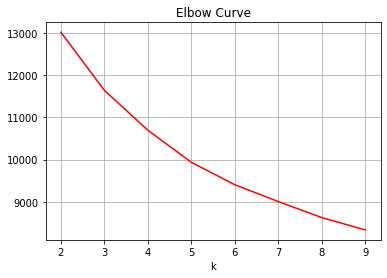

In [ ]:
features = ["track_popularity","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo", "duration_ms", "track_album_release_year"]

data_normed_quanti = normalisation(spotify_data_cleaned)

data_normed_quanti.loc[:, features].mean()

from sklearn.cluster import KMeans
X = data_normed_quanti[features]
distorsions = []
for k in range(2,10):
    model = KMeans(n_clusters=k)
    model.fit(X)
    distorsions.append(model.inertia_)
plt.plot(range(2,10), distorsions, color='red')
plt.grid(True)
plt.xlabel('k')
plt.title('Elbow Curve')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne_obj = TSNE()
tsne = tsne_obj.fit_transform(data_normed_quanti)
tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
y = tsne_df.y
tsne_df['label'] = y

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyboardInterrupt: 

In [ ]:
sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', palette='Dark2')



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 391x457943 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

**coup dur**

In [ ]:
plt.title("Songs' Clustering Visualization using t-SNE")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2ad4461-7f35-42f5-b2d9-f686e8952f67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>